# **Data Visualisation - Brain Tumor Detection**

## Objectives



## Inputs



## Outputs




## Comments/Conclusions

---

## Set Data Directory

---

### Import Libraries

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
sns.set_style("white")
from matplotlib.image import imread

## Set Working Directory

In [2]:
cwd= os.getcwd()

In [3]:
os.chdir('/workspace/brain-tumor-detection')
print("You set a new current directory")

You set a new current directory


In [4]:
work_dir = os.getcwd()
work_dir

'/workspace/brain-tumor-detection'

## Set Input Directories

Set test, train and validation paths

In [5]:
my_data_dir = 'inputs/mriscans_dataset/mri-scans'
test_path = my_data_dir + '/test'
train_path = my_data_dir + '/train'
validation_path = my_data_dir + '/validation'

## Set Output Directory

In [6]:
version = 'v1'
file_path = f'outputs/{version}'

if 'outputs' in os.listdir(work_dir) and version in os.listdir(work_dir + '/outputs'):
    print('Old version is already available create a new version.')
    pass
else:
    os.makedirs(name=file_path)

## Set Label Names

In [7]:
labels = os.listdir(train_path)
print('Label for the images are', labels)

Label for the images are ['healthy', 'tumor']


---

# Data Visualisation of Image Data

---

## Image Shape

It is recommended to normalise image pixel values relative to tge dataset mean and standard deviation. This will help get constant results when applying a model to new images and it can also be useful for transfer learning. 

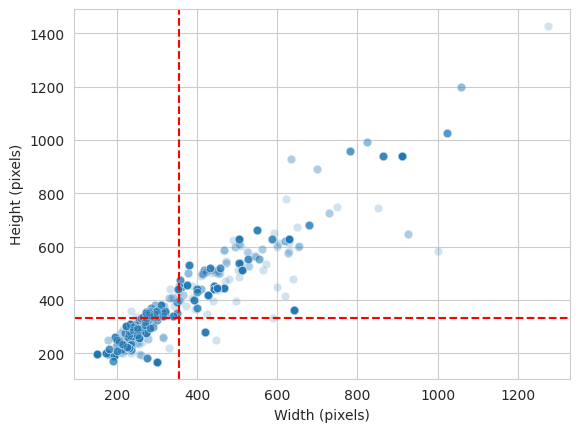

Width average: 334 
Height average: 355


In [8]:
# Analyse the dimensions of the images
image_height, image_width = [], []
for label in labels:
    for image_file in os.listdir(os.path.join(train_path, label)):
        image = imread(os.path.join(train_path, label, image_file))
        image_height.append(image.shape[0])
        image_width.append(image.shape[1])

# Plot image dimensions on a graph
sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=image_width, y=image_height, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
image_height_mean = int(np.array(image_height).mean())
image_width_mean = int(np.array(image_width).mean())
axes.axvline(x=image_height_mean, color='r', linestyle='--')
axes.axhline(y=image_width_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {image_width_mean} \nHeight average: {image_height_mean}")

The images used in this dataset vary in size, therefore, this is the information that the graph above has shown

### Images size for training the model is the average from all images in the train set

In [9]:
image_shape = (image_height_mean, image_width_mean, 3)
image_shape

(355, 334, 3)

### Save the image shape embeddings

In [10]:
joblib.dump(value=image_shape ,
            filename=f"{file_path}/image_shape.pkl")

['outputs/v1/image_shape.pkl']

---

## Average and Variability of Images Per Label

### Load Images in an Array

In [11]:
from tensorflow.keras.preprocessing import image


def load_image_as_array(my_data_dir, new_size=(50, 50), n_images_per_label=20):

    X, y = np.array([], dtype='int'), np.array([], dtype='object')
    labels = os.listdir(my_data_dir)

    for label in labels:
        counter = 0
        for image_filename in os.listdir(my_data_dir + '/' + label):
            # n_images_per_label: we set a limit, since it may take too much time
            if counter < n_images_per_label:

                img = image.load_img(
                    my_data_dir + '/' + label + '/' + image_filename, target_size=new_size)
                if image.img_to_array(img).max() > 1:
                    img_resized = image.img_to_array(img) / 255
                else:
                    img_resized = image.img_to_array(img)

                X = np.append(X, img_resized).reshape(-1,
                                                      new_size[0], new_size[1], img_resized.shape[2])
                y = np.append(y, label)
                counter += 1

    return X, y

### Load Image Shapes and Labels in an Array

In [12]:
X, y = load_image_as_array(my_data_dir=train_path,
                           new_size=image_shape,
                           n_images_per_label=30)
print(X.shape, y.shape)

(60, 355, 334, 3) (60,)


### Plot and Save Mean and Variability of Images per Label

In [13]:
def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    """
    The pseudo-code for the function is:
    * Loop over all labels
    * Subset an array for a given label
    * Calculate the mean and standard deviation
    * Create a figure displaying the mean and variability of images
    * Save the image
    """

    for label_to_display in np.unique(y):
        sns.set_style("white")

        y = y.reshape(-1, 1, 1)
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]

        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average image for label {label_to_display}")
        axes[0].imshow(avg_img, cmap='gray')
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img, cmap='gray')

        if save_image:
            plt.savefig(f"{file_path}/avg_var_{label_to_display}.png",
                        bbox_inches='tight', dpi=150)
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

==== Label healthy ====
Image Shape: (355, 334, 3)
==== Label tumor ====
Image Shape: (355, 334, 3)


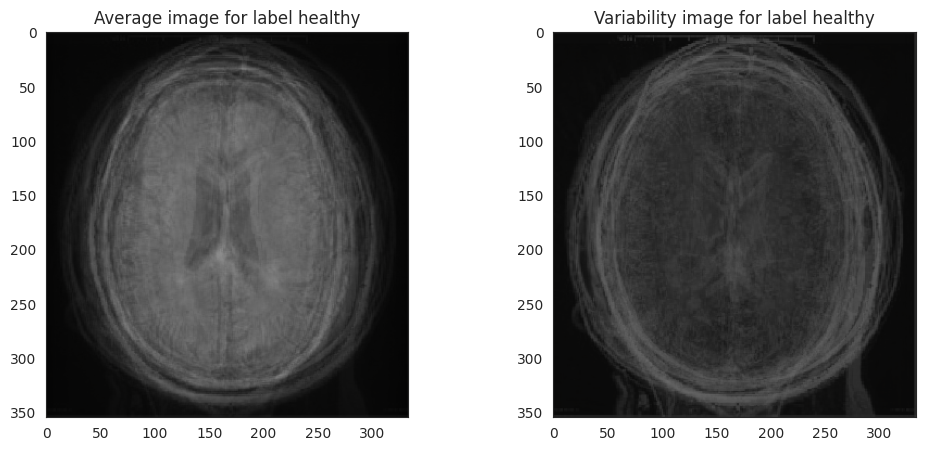

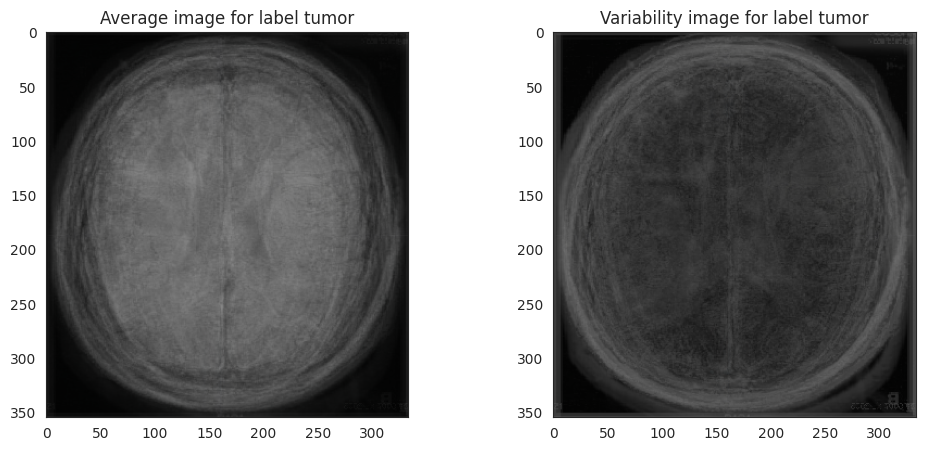

In [14]:
plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)

---

## Difference Between an Average Healthy Brain MRI Scan and Average Tumor MRI Scan

---

In [15]:
def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    """
    Checks if the labels exist in the set of unique labels
    Calculates the mean and difference for label1 and label2
    Plots a chart and saves it if save_image=True
    """
    sns.set_style("white")

    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(
            f"Either label {label} or label {label_2}, are not in {np.unique(y)} ")
        return

    # calculate mean from label1
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)

    # calculate mean from label2
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)

    # calculate difference and plot difference, avg label1 and avg label2
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg, cmap='gray')
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg, cmap='gray')
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean, cmap='gray')
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
        plt.savefig(f"{file_path}/avg_diff.png", bbox_inches='tight', dpi=150)
    else:
        plt.tight_layout()
        plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


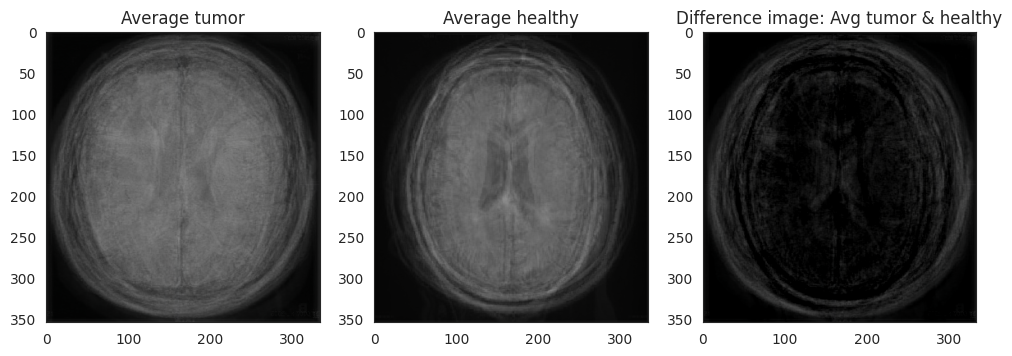

In [17]:
diff_bet_avg_image_labels_data_as_array(X=X, y=y,
                                        label_1='tumor', label_2='healthy',
                                        figsize=(12, 10),
                                        save_image=True
                                        )